# SIFT tracking enhanced - Drift problem

In [41]:
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import sys
import time
import AuxFunctions

In [39]:
def getObjectMask(img, bb):
    mask=np.empty(img.shape, dtype=np.uint8)
    mask.fill((255))
    mask = np.zeros(img.shape, dtype=np.uint8)
    # bounding box region is white
    mask = cv2.rectangle(mask, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,255,255), thickness = -1)
    return mask


In [37]:
def getCroppedBB(img, bb):
    img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [36]:
def getObjectCropped(pts, im):
    minP = pts[0].squeeze()
    maxP = pts[2].squeeze()
    
    h = maxP[0]-minP[0]
    w = maxP[1] - minP[1]
    return im[minP[1]:minP[1]+w, minP[0]:minP[0] + h]

In [69]:
def pointsToBB(pts):
    minP = pts[0].squeeze()
    maxP = pts[2].squeeze()
    
    h = maxP[0]-minP[0]
    w = maxP[1] - minP[1]
    return (minP[0], minP[1], h, w)

---

In [70]:
# returns: status, result image with the bounding box, cropped ROI
def getMinDescriptors(obj, frame, per):
    # original shape
    w,h = obj.shape

    # get center of the image
    c = (h/2, w/2)
    # new area shape
    h = int(h*per)
    w = int(w*per)
    # build new box
    topLeft = (int(c[0]-h/2), int(c[1]-w/2))
    #newObj = obj[topLeft[0]:(topLeft[0]+h), topLeft[1]:(topLeft[1]+w)]
    

    # Extract the features
    sift = cv2.xfeatures2d.SIFT_create() 
        # Object features
    mask = getObjectMask(obj, (topLeft[0], topLeft[1], h, w))    
        
    objectKp, objectDescriptors = sift.detectAndCompute(obj, mask = mask)
    
        # Frame features
    frameKp, frameDescriptors = sift.detectAndCompute(frame, None)
    
    # Matcher ------------------------
        # Matcher parameters
    FLANN_INDEX_KDTREE = 1
    MINIMUM_MATCHES_COUNT = 5

    index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees  =5)
    search_params = dict(checks = 50)
    
        # setup the matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(objectDescriptors, frameDescriptors, k=2)
    
    bestMatches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            bestMatches.append(m)

    if len(bestMatches) > 5:
        src_pts = np.float32([ objectKp[m.queryIdx].pt for m in bestMatches ]).reshape(-1,1,2)
        dst_pts = np.float32([ frameKp[m.trainIdx].pt for m in bestMatches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=3.0)

        # check if the homography finding has failed
        if M is None or M.size == 0:
            print("The estimation for the homography matrix has failed.")
            return -1, None, None

        matchesMask = mask.ravel().tolist()
        h,w = obj.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        dst = cv2.perspectiveTransform(pts,M)

        if dst is None:
            print("The perspective transform estimation has failed.")
            return -1, None, None, None

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

        
        
        # extract the ROI
        frameCopy = frame.copy()
        ROI = getObjectCropped(np.int32(dst), frame)
        
        predictedBox = pointsToBB(np.int32(dst))
        
        frameCopy = frame.copy()
        #result = cv2.rectangle(frameCopy, np.int32(dst)[0][0], np.int32(dst)[2][0], (255,0,0), thickness=3)
        result = cv2.rectangle(frameCopy, (predictedBox[0], predictedBox[1]), (predictedBox[0]+predictedBox[2], predictedBox[1]+predictedBox[3]), (255,0,0), thickness=3)
        return 1, result, ROI, predictedBox
    else:
        return -1, None, None, None
    
    
    
    

In [74]:
def runTracker(mainDirectory = "./datasets/Drone1", maxFramesToShow = 5, showEveryX=1):
    intersectionMetric = []
    centroidDistanceMetric = []
    
    
    # get bounding boxes data
    filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
    try:
        bbs = AuxFunctions.getBoundingBoxes(filepathBB)
    except:
        print("Haven't been found the groundtruth_rect.txt file")

    # analyze the first frame
    imgPath = os.path.join(mainDirectory, "img")
    file = os.path.join(imgPath, "00001.jpg")
    firstFrame = cv2.imread(file)

    obj = getCroppedBB(firstFrame, bbs[1])

    numFrame = 1
    framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))
    for filename in os.listdir(imgPath)[2:framesToShow]:
        
        # reading the frame
        filepath = os.path.join(imgPath, filename)   
        frame = plt.imread(filepath)
        
        per = 0.4
        x, result, ROI, predictedBox = getMinDescriptors(obj,frame, per)
        
        while (per <= 1 and x == -1):
            per += 0.1
            x, result,ROI, predictedBox = getMinDescriptors(obj,frame, per)
        
        # Compute both prediction metrics
        intersectionMetric.append(AuxFunctions.getMetricIntesection(bbs[numFrame],predictedBox))
        centroidDistanceMetric.append(AuxFunctions.getMetricCentDist(bbs[numFrame],predictedBox))
        
        if(x == -1):
            print("Tracking interrupted on frame" + str(numFrame))
            return -1
        
        # if a transformation is found, recalculate the object ROI
        obj = ROI
        obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
        
        if(numFrame % showEveryX == 0):
            fig,ax = plt.subplots()
            ax.imshow(result)
            plt.show()
        numFrame+=1
    return intersectionMetric, centroidDistanceMetric

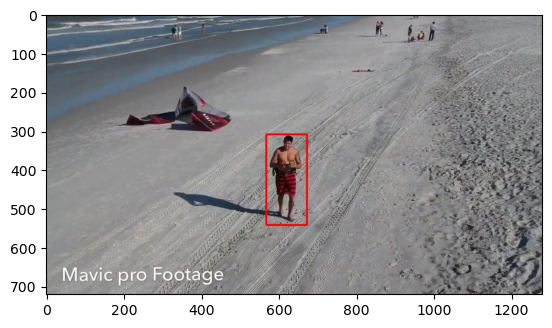

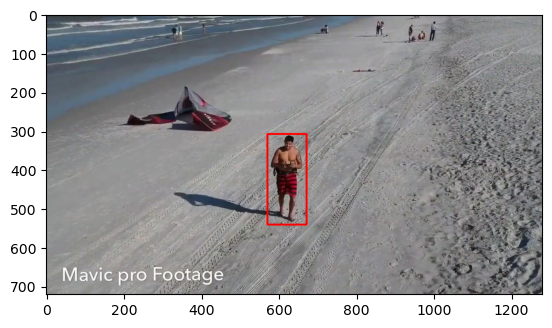

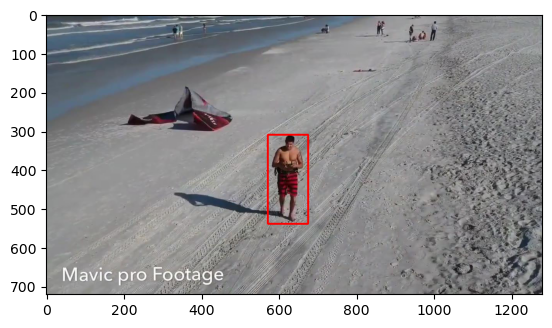

[0.8339814300452345, 0.8594255746302291, 0.8601330520850236]

In [75]:
intersectionMetric, centroidDistanceMetric = runTracker()
intersectionMetric